# Control on Gym Pendulum

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathisfederico/controlgym/blob/master/notebooks/lqr.ipynb)

# Setup

## Environment

In [1]:
!pip install git+https://github.com/MathisFederico/ControlGym.git
!apt-get install -y xvfb x11-utils
!pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate
!apt-get install -y ffmpeg

  Cloning https://github.com/MathisFederico/ControlGym.git to c:\users\mathi\appdata\local\temp\pip-req-build-56du73c0
  Resolved https://github.com/MathisFederico/ControlGym.git to commit b6c81fafcfa5bf17020b7b1a1ea410fc8554f55f
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/MathisFederico/ControlGym.git 'C:\Users\mathi\AppData\Local\Temp\pip-req-build-56du73c0'

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt-get' is not recognized as an internal or external command,
operable program or batch file.



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


## Rendering

In [2]:
import sys
from controlgym.video import show_video, record_video

if not sys.platform.startswith('win32'):
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(1400, 900))
    display.start()

# Pendulum

## Start at equilibrium

### Random Agent

In [3]:
from gym.wrappers.time_limit import TimeLimit
from controlgym.envs.pendulum import UpPendulumEnv

upenv = UpPendulumEnv(g=9.81)
upenv = TimeLimit(upenv, max_episode_steps=200)

In [4]:
from controlgym.agents import RandomAgent
random_agent = RandomAgent(upenv.action_space)
record_video(upenv, random_agent)
show_video()

### LQR Control

In [5]:
import control as ct
import control.matlab as ctm
import numpy as np
from gym.envs.classic_control.pendulum import PendulumEnv

def get_pendulum_linear_model(env: PendulumEnv, costheta:float=1):
    l = env.l
    g = env.g
    m = env.m
    dt = env.dt
    s = costheta

    A = np.array([
        [0, 1],
        [s * g / l, 0],
    ])

    B = np.array([
        [0], [-3 / (m * l ** 2)]
    ])

    C = np.eye(2)

    D = np.zeros((2, 1))

    continuous_model = ct.ss(A, B, C, D)
    return ctm.c2d(continuous_model, Ts=dt)

upmodel = get_pendulum_linear_model(upenv, 1)
upmodel

<LinearIOSystem:sys[2]$sampled:['u[0]']->['y[0]', 'y[1]']>

In [6]:
def get_pendulum_linear_lqr_gain(model: ct.StateSpace):
    Qx1 = np.diag([1, 0.1])
    Qu1a = np.diag([0.001])
    K, _, _ = ct.lqr(model, Qx1, Qu1a)
    return np.array(K)

K = get_pendulum_linear_lqr_gain(upmodel)
K

array([[-17.90204232,  -5.67967853]])

In [7]:
from controlgym.agents.control import LinearControlAgent

def pendulum_obs_to_state(observation) -> np.ndarray:
    x, y, theta_dot = observation
    theta = np.arctan2(y, x)
    return np.array([theta, theta_dot])

control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)
observations, actions, times = record_video(upenv, control_agent)

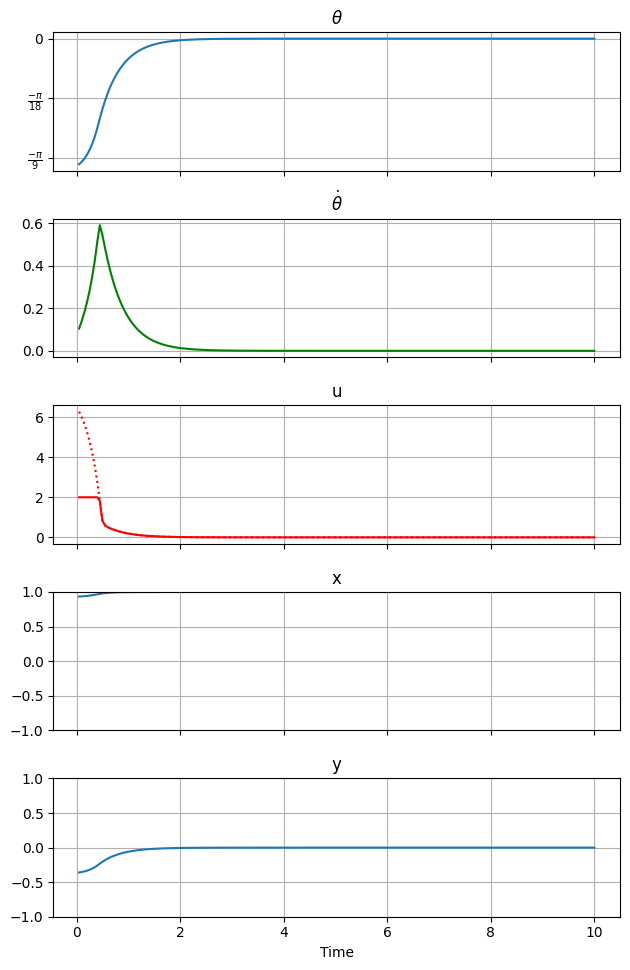

In [8]:
import numpy as np
from controlgym.envs.pendulum import plot_pendulum_history, thetas_from_obs

thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=upenv.max_torque)
show_video()

## Start at bottom position

In [9]:
from controlgym.envs.pendulum import DownPendulumEnv

downenv = DownPendulumEnv(g=9.81)
downenv = TimeLimit(downenv, max_episode_steps=200)

### Random agent

In [10]:
random_agent = RandomAgent(downenv.action_space)
record_video(downenv, random_agent)
show_video()

### LQR Control

In [11]:
model = get_pendulum_linear_model(downenv, 1)
K = get_pendulum_linear_lqr_gain(model)
control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)
observations, actions, times = record_video(downenv, control_agent)

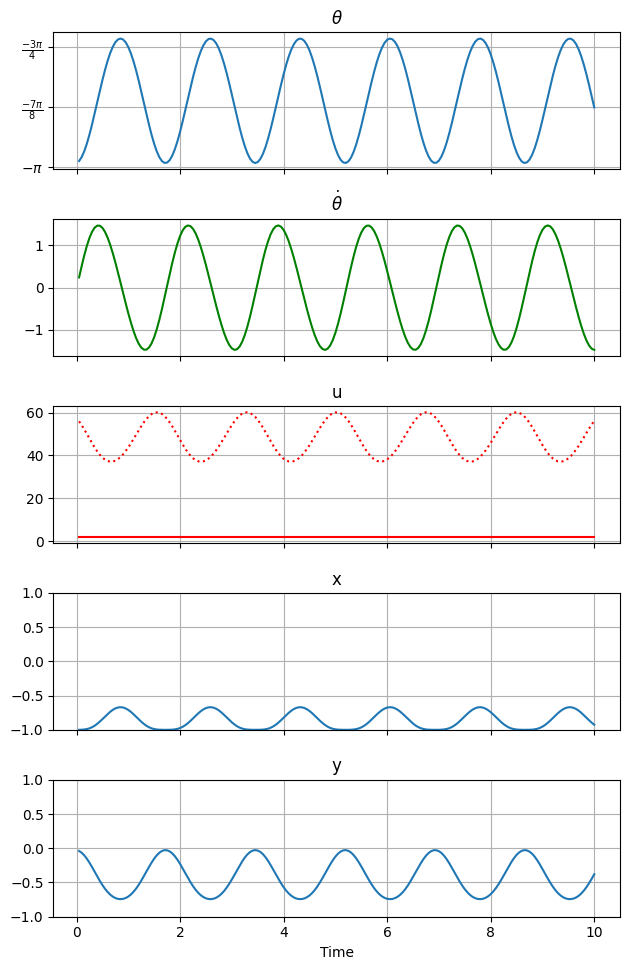

In [12]:
thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
show_video()

### HEBG + LQR Control

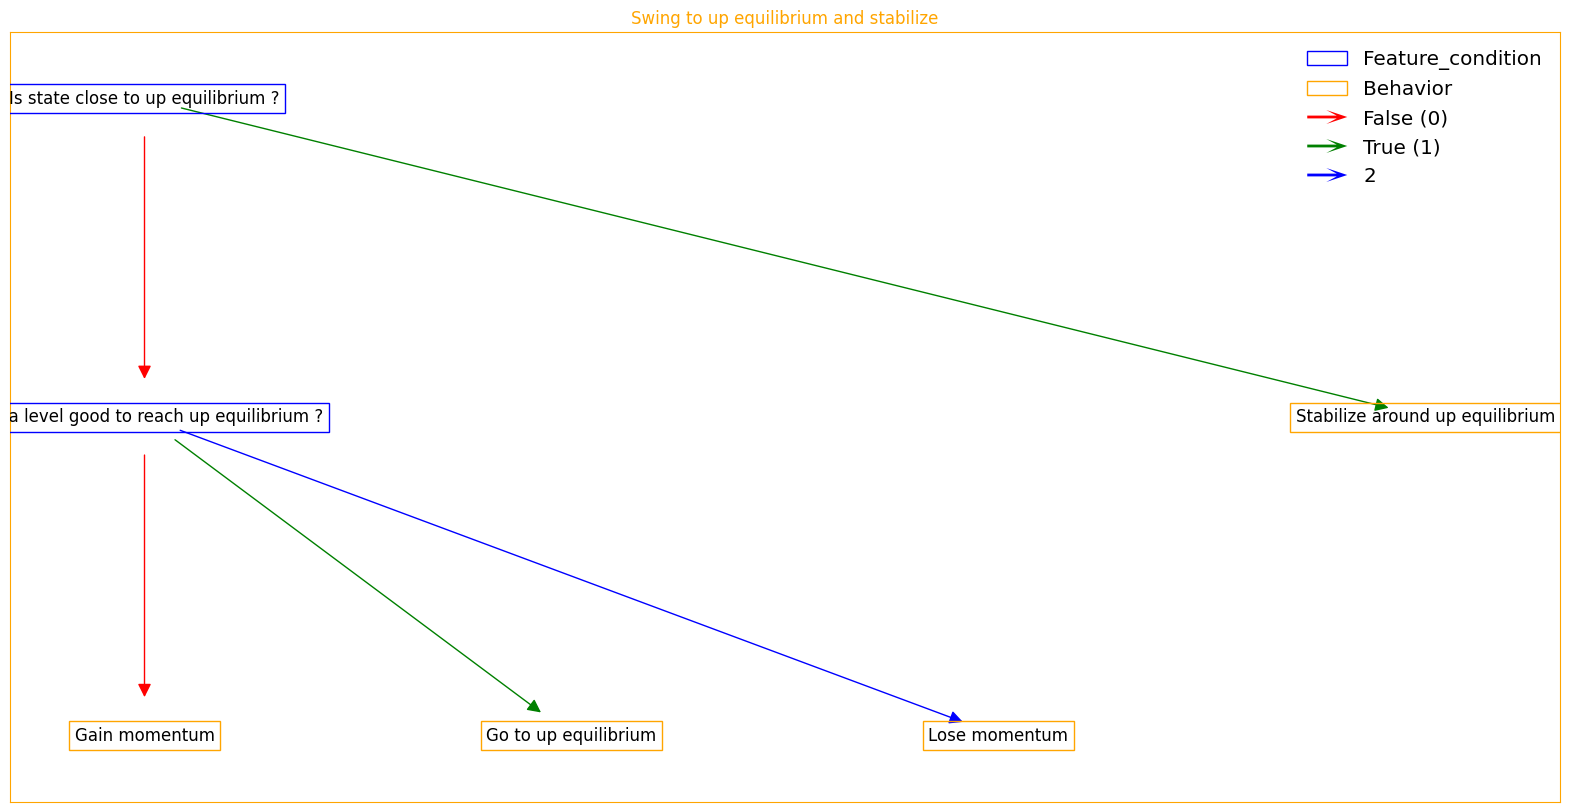

In [13]:
from hebg import HEBGraph, FeatureCondition, Behavior

call_history = []

class IsCloseToUpEquilibrium(FeatureCondition):
   def __init__(self) -> None:
      super().__init__(name="Is state close to up equilibrium ?")
   def __call__(self, observation):
      close_in_x = np.abs(observation[0]-1) < np.sqrt(3)/2
      close_in_y = np.abs(observation[1]) < 1/2
      not_too_fast = np.abs(observation[2]) < 3
      return close_in_x and close_in_y and not_too_fast


class StabilizeAroundUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Stabilize around up equilibrium")
        model = get_pendulum_linear_model(downenv, 1)
        K = get_pendulum_linear_lqr_gain(model)
        self.control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return self.control_agent.act(observation)


class InertiaLevel(FeatureCondition):
    def __init__(self) -> None:
        super().__init__(name="Inertia level good to reach up equilibrium ?")
        self.g = downenv.g

    def __call__(self, observation):
        z = observation[0] + 1
        inertia = np.power(observation[2], 2)/2 + self.g*z
        if inertia < 2 * self.g:
            return 0 # Too slow
        if inertia > 3 * self.g:
            return 2 # Too fast
        return 1

class GainMomentum(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Gain momentum")
        self.max_torque = downenv.max_torque

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return np.array([self.max_torque * np.sign(observation[2])])

class LoseMomentum(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Lose momentum")
        self.max_torque = downenv.max_torque

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return np.array([- self.max_torque * np.sign(observation[2])])

class GoToUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Go to up equilibrium")
        model = get_pendulum_linear_model(downenv, -1)
        K = get_pendulum_linear_lqr_gain(model)
        self.control_agent = LinearControlAgent(K, obs_to_state=pendulum_obs_to_state)

    def __call__(self, observation, *args, **kwargs):
        call_history.append(self.name)
        return self.control_agent.act(observation)

class SwingToUpEquilibrium(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Swing to up equilibrium")
    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        inertia_level = InertiaLevel()
        graph.add_edge(inertia_level, GainMomentum(), index=0)
        graph.add_edge(inertia_level, LoseMomentum(), index=2)
        graph.add_edge(inertia_level, GoToUpEquilibrium(), index=1)
        return graph

class SwingUpAndStabilize(Behavior):
    def __init__(self) -> None:
        super().__init__(name="Swing to up equilibrium and stabilize")
    def build_graph(self) -> HEBGraph:
        graph = HEBGraph(self)
        is_close_to_up_eq = IsCloseToUpEquilibrium()
        graph.add_edge(is_close_to_up_eq, SwingToUpEquilibrium(), index=int(False))
        graph.add_edge(is_close_to_up_eq, StabilizeAroundUpEquilibrium(), index=int(True))
        return graph

swing_up_behavior = SwingUpAndStabilize()

# Obtain networkx graph
graph = swing_up_behavior.graph

# Draw graph using matplotlib
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[20, 10], dpi=100)
graph.unrolled_graph.draw(ax)
plt.show()

In [14]:
from controlgym.agents import HEBGAgent

swing_up_hebg_agent = HEBGAgent(swing_up_behavior)
call_history = []
observations, actions, times = record_video(downenv, swing_up_hebg_agent)

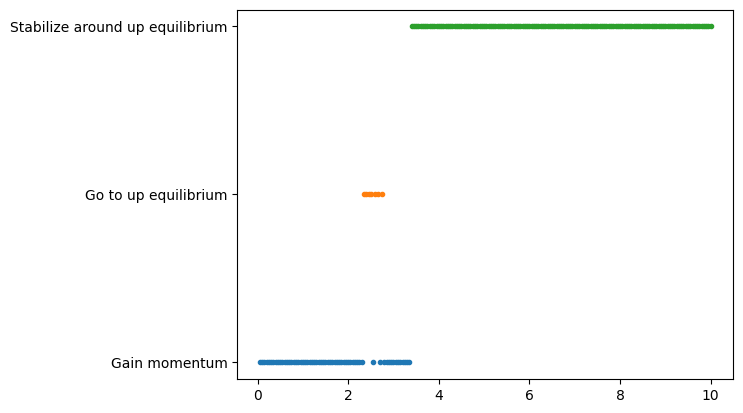

In [15]:
from controlgym.plotting import plot_hebg_call_history

plot_hebg_call_history(times, call_history)

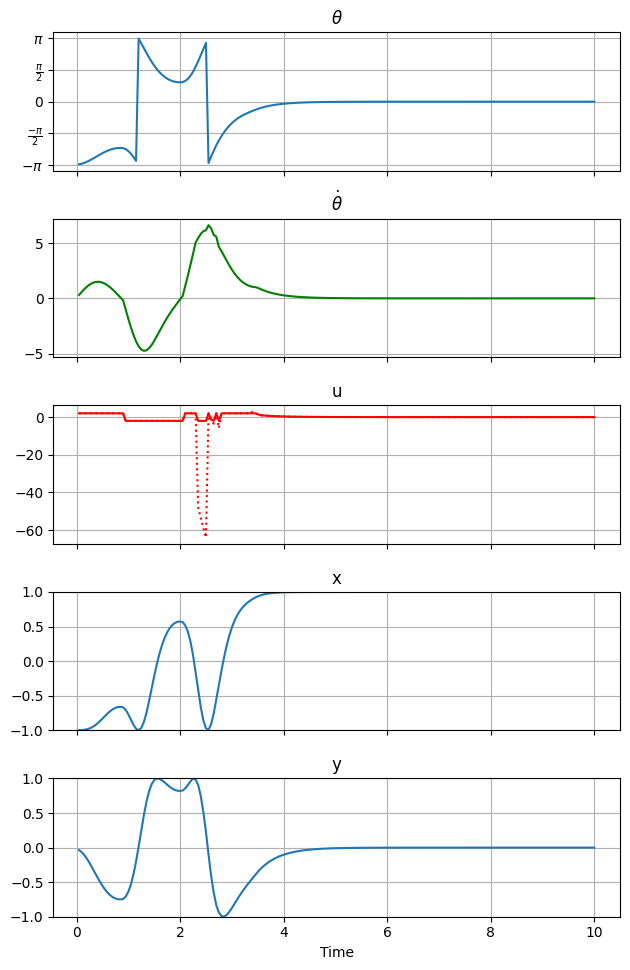

In [16]:
thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
show_video()

## Start at completely random position & speed

### Random Agent

In [17]:
from controlgym.envs.pendulum import RandomPendulumEnv

randenv = RandomPendulumEnv(g=9.81)
randenv = TimeLimit(randenv, max_episode_steps=200)

In [18]:
random_agent = RandomAgent(randenv.action_space)
record_video(randenv, random_agent)
show_video()

### HEBG + LQR Control

In [19]:
call_history = []
observations, actions, times = record_video(randenv, swing_up_hebg_agent)

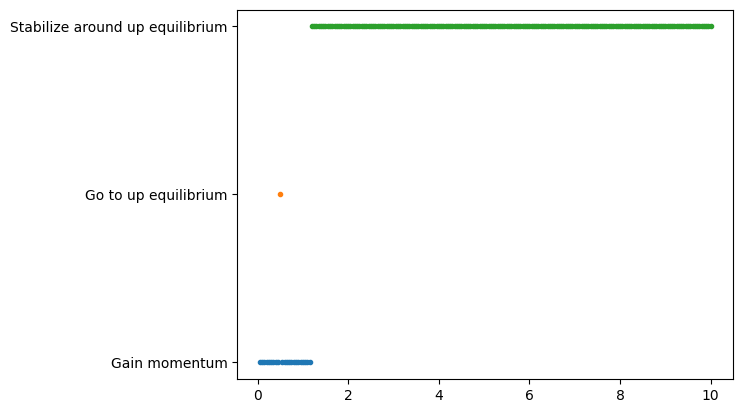

In [20]:
plot_hebg_call_history(times, call_history)

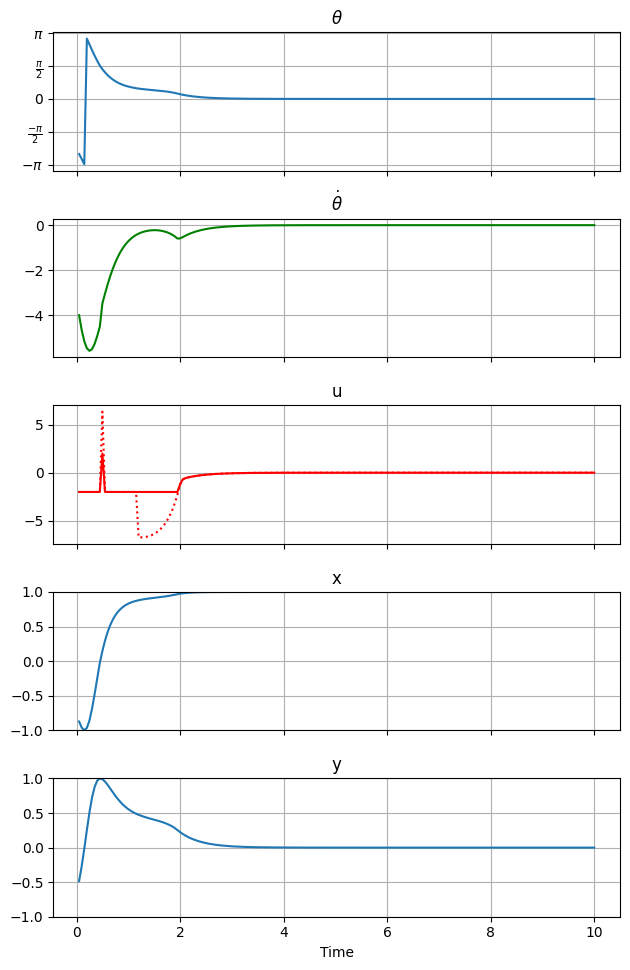

In [21]:
thetas, thetadots = thetas_from_obs(observations)
plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
show_video()

### MPC Control

In [22]:
import control.optimal as obc
from controlgym.envs.pendulum import pendulum_rhs

io_pendulum = ct.NonlinearIOSystem(
    pendulum_rhs, None, inputs=('u'), outputs=(r'$\theta$', r'$\dot\theta$'),
    states=(r'$\theta$', r'$\dot\theta$'), name='pendulum')

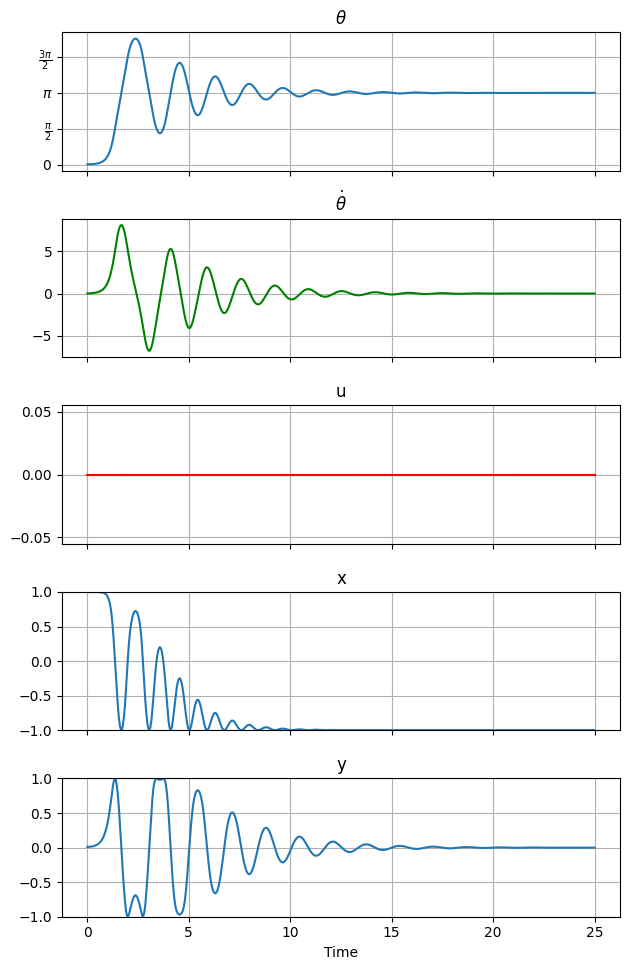

In [23]:
X0 = [0.01, 0]
T = np.linspace(0, 25, 500)
U = np.zeros_like(T)

# Simulate the system
t, y = ct.input_output_response(io_pendulum, T, U, X0)
plot_pendulum_history(T, U, y[0], y[1])

In [24]:
from scipy.optimize import LinearConstraint
from control.optimal import OptimalControlProblem


def pendulum_cost(t, x, u):
    return x[0]**2 + 0.1 * x[1]**2 + 0.001 * u[0]

high = np.array([2 * np.pi, downenv.max_speed, downenv.max_torque])

pendulum_constraints = [LinearConstraint(np.diag([0, 1, 1]), -high, high)]

R = np.diag([0.1])               # keep inputs small
P = np.diag([1000, 500])   # get close to final point
traj_cost = obc.quadratic_cost(io_pendulum, 0, R, x0=0)
term_cost = obc.quadratic_cost(io_pendulum, P, 0, x0=0)

Tf = 3
n_points = int(Tf/downenv.dt)
timepts = np.linspace(0, Tf, n_points, endpoint=True)
print(n_points)

pendulum_optimal_problem = OptimalControlProblem(
    io_pendulum,
    timepts,
    integral_cost=traj_cost,
    trajectory_constraints=pendulum_constraints,
    terminal_cost=term_cost,
    minimize_options={"maxiter": 1000}
)


60


In [25]:
result = pendulum_optimal_problem.compute_trajectory(X0)
result.success

Summary statistics:
* Cost function calls: 548
* Constraint calls: 733
* System simulations: 1
* Final cost: 0.0001201715822591471


True

In [26]:
# # Simulate the system dynamics (open loop)
# resp = ct.input_output_response(
#     io_pendulum,
#     timepts,
#     U=result.inputs,
#     X0=X0,
#     t_eval=timepts
# )

# t, y, u = resp.time, resp.outputs, resp.inputs

# theta, thetadots = y[0], y[1]

# ax = plt.subplot(3, 1, 1)
# ax.plot(t, theta)
# ax.plot(t, np.zeros_like(t), linestyle='--', label='Equilibrium')
# ax.set_ylabel(r"$\theta$")

# ax = plt.subplot(3, 1, 2)
# ax.plot(t, thetadots, color="g")
# ax.set_ylabel(r"$\dot\theta$")

# ax = plt.subplot(3, 1, 3, sharex=ax)
# ax.plot(t, u[0], color="r")
# ax.set_ylabel("u")

# plt.xlabel("Time (s)")

# plt.suptitle("Pendulum internal simulation")

# plt.tight_layout()
# plt.show()

In [27]:
# from control.optimal import OptimalControlProblem

# class MPCAgent(Agent):
#     def __init__(self, opc_problem: OptimalControlProblem, obs_to_state=lambda x:x):
#         self.opc_problem = opc_problem
#         self.obs_to_state = obs_to_state

#     def act(self, observation):
#         state = self.obs_to_state(observation)
#         res = self.opc_problem.compute_trajectory(state, print_summary=False)
#         return res.inputs[:, 0]

# control_agent = MPCAgent(pendulum_optimal_problem, obs_to_state=pendulum_obs_to_state)
# observations, actions, times = record_video(downenv, control_agent)

In [28]:
# thetas, thetadots = thetas_from_obs(observations)
# plot_pendulum_history(times, actions, thetas, thetadots, max_torque=downenv.max_torque)
# show_video()